word2vec, kmeans 군집화, RF 에측

In [5]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from bs4 import BeautifulSoup
import re
import time

from nltk.corpus import stopwords
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
model = Word2Vec.load('300features_40minwords_10text')
model

### Word2Vec

* 단어를 숫자로 표현. Word2Vec 모델은 각 단어에 대한 feature 벡터로 구성되며 'syn0' 이라는 넘파이 배열로 저장된다
* syn0 의 행 수는 모델 어휘의 단어 수
* syn0 의 컬럼 수는 설정한 피처 벡터의 크기




In [8]:
type(model.wv.syn0)

/Users/leesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [10]:
model.wv.syn0.shape

/Users/leesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(11986, 300)

In [11]:
model.wv['flower'].shape

(300,)

In [12]:
model.wv['flower'][:10]

array([-0.09041259,  0.13723384,  0.04802566, -0.09356543,  0.05572526,
        0.05693802,  0.01356911, -0.05439005, -0.02723891,  0.03461557], dtype=float32)

## K-means (K평균) 클러스터링으로 데이터 묶기

In [15]:
start = time.time()

# k를 어휘 크기의 1/5 이나 평균 5단어로 설정한다
word_vectors = model.wv.syn0
num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

/Users/leesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


Time taken for K Means clustering:  194.176127910614 seconds.


In [18]:
idx = list(idx)

names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}

for cluster in range(0, 10):
    print("\nCLuster {}".format(cluster))
    
    words = []
    for i in range(0, len(list(word_centroid_map.values()))):
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


CLuster 0
['wender']

CLuster 1
['alicia', 'deanna', 'eliza', 'stacey', 'silverston', 'dushku', 'jacey']

CLuster 2
['cage', 'steel', 'jeffrey', 'comb', 'jefferi', 'crockett', 'vogel', 'jc', 'rand']

CLuster 3
['asia', 'canyon', 'atlant', 'northwest', 'southwest']

CLuster 4
['neglect']

CLuster 5
['rebel', 'fought', 'inmat', 'civilian', 'wage', 'casualti', 'faction', 'insurg']

CLuster 6
['enter', 'rear', 'darken', 'furnish']

CLuster 7
['beauti', 'stun', 'breathtak', 'eleg', 'glorious', 'exquisit', 'dazzl', 'lush', 'vibrant', 'evoc', 'sumptuous', 'wondrous', 'majest', 'opul']

CLuster 8
['bubbl', 'gum', 'pancak']

CLuster 9
['subvers', 'misus', 'condon', 'rhetor', 'scath', 'leftist', 'denounc', 'elitist', 'misinterpret', 'marxist', 'semit', 'docudrama', 'misinform', 'fervent', 'dissent', 'authoritarian']


## Load Dataset

In [19]:
train = pd.read_csv('data/labeledTrainData.tsv', 
                    header=0, delimiter="\t", quoting=3)
test = pd.read_csv('data/testData.tsv', 
                   header=0, delimiter="\t", quoting=3)

In [20]:
from KaggleWord2VecUtility import KaggleWord2VecUtility
# 학습 리뷰를 정제한다.
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, remove_stopwords=True ))

In [21]:
# 테스트 리뷰를 정제한다.
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, remove_stopwords=True ))

In [23]:
# bags of centroids 생성
# 속도를 위해 centroid 학습 세트 bag을 미리 할당 한다.
train_centroids = np.zeros((train["review"].size, num_clusters), dtype="float32" )

train_centroids[:5]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [24]:
# centroid 는 두 클러스터의 중심점을 정의 한 다음 중심점의 거리를 측정한 것
def create_bag_of_centroids( wordlist, word_centroid_map ):
    
    # 클러스터의 수는 word / centroid map에서 가장 높은 클러스트 인덱스와 같다.
    num_centroids = max( word_centroid_map.values() ) + 1
    
    # 속도를 위해 bag of centroids vector를 미리 할당한다.
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    # 루프를 돌며 단어가 word_centroid_map에 있다면
    # 해당되는 클러스터의 수를 하나씩 증가시켜 준다.
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # bag of centroids를 반환한다.
    return bag_of_centroids

In [25]:
# 학습 리뷰를 bags of centroids 로 변환한다.
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# 테스트 리뷰도 같은 방법으로 반복해 준다.
test_centroids = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1


# 랜덤포레스트를 사용하여 학습시키고 예측
forest = RandomForestClassifier(n_estimators = 100)

# train 데이터의 레이블을 통해 학습시키고 예측한다.
# 시간이 좀 소요되기 때문에 %time을 통해 걸린 시간을 찍도록 함
print("Fitting a random forest to labeled training data...")
%time forest = forest.fit(train_centroids, train["sentiment"])

Fitting a random forest to labeled training data...
CPU times: user 27.2 s, sys: 482 ms, total: 27.7 s
Wall time: 28.2 s


In [26]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_centroids, train['sentiment'], cv=10,\
    scoring='roc_auc'))

CPU times: user 3min 49s, sys: 2.21 s, total: 3min 52s
Wall time: 3min 54s


In [27]:
%time result = forest.predict(test_centroids)

CPU times: user 1.12 s, sys: 134 ms, total: 1.25 s
Wall time: 1.25 s


In [28]:
score

0.91594496000000003

In [29]:
# 결과를 csv로 저장
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("data/submit_BagOfCentroids_{0:.5f}.csv".format(score), index=False, quoting=3)

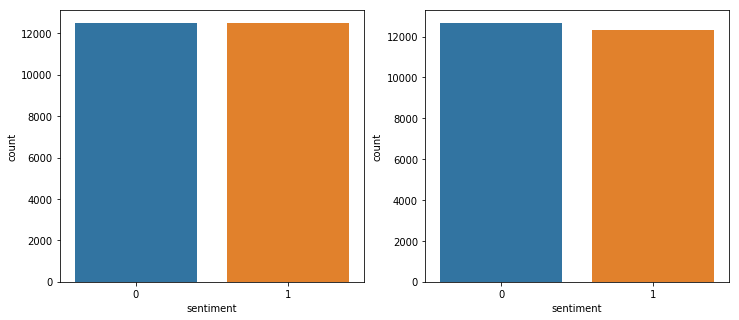

In [30]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [31]:
# 네거티브 데이터와 파지티브 데이터가 차이남
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

340


0    12670
1    12330
Name: sentiment, dtype: int64